In [2]:
import numpy as np
import astra
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator, lsqr
from scipy.sparse.linalg import LinearOperator, cg
import pywt


from skimage.metrics import structural_similarity as ssim

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix


# Advanced Topic 1: Inpainting in Sinogram Space

### Create sinogram data for both cases i) full angle with undersampled projections, ii) limitedangles. Create a full size sinogram by adding zeros in the columns corresponding to missing measurements.

### Create a full size sinogram by adding zeros in the columns corresponding to missing measurements

### 

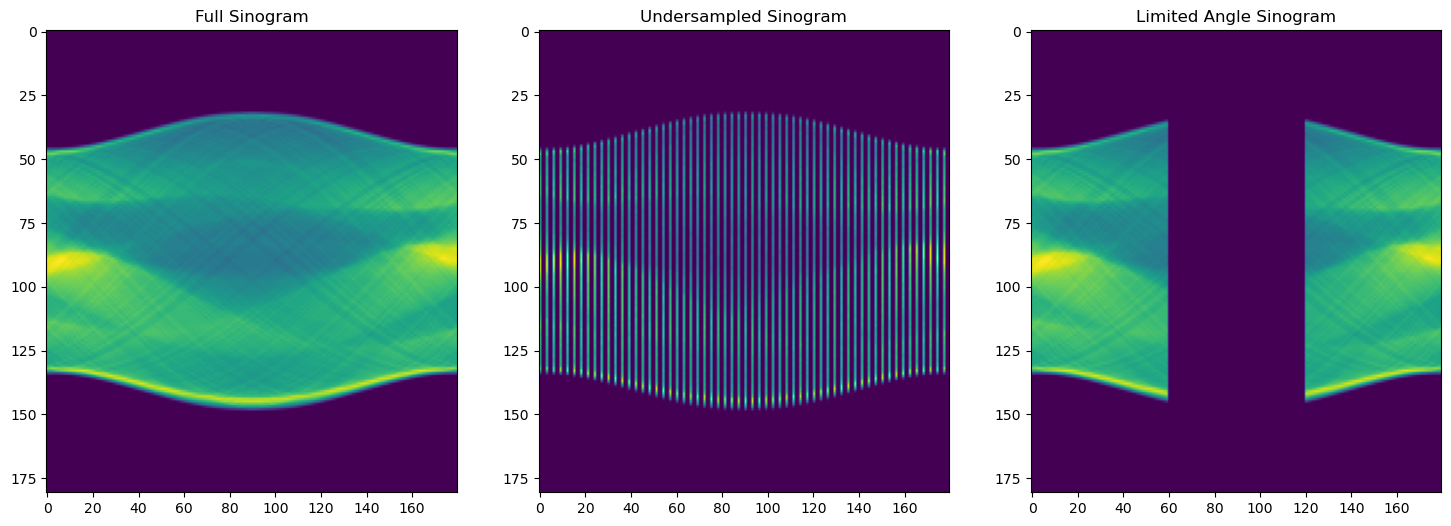

In [3]:


# 1. Load the Shepp-Logan phantom image
img_size = 128
SLphan_img = np.load('SLphan.npy')  # Assume 128 x 128 loaded correctly
f_true = SLphan_img

# 2. Set up the number of detectors, which is typically more than the size to capture all angles
det_count = int(np.sqrt(img_size**2 + img_size**2))

# 3. Create projection geometries
angles_full = np.linspace(0, np.pi, 180, endpoint=False)  # Full set of 180 projections
angles_under = angles_full[::3]  # Every third angle, creating undersampling
angles_limited = np.linspace(0, np.pi, 60, endpoint=False)  # Limited angle, 60 projections

# 4. Create projection data (sinograms)
def create_sinogram(img, angles, det_count):
    # Create projector
    proj_geom = astra.create_proj_geom('parallel', 1.0, det_count, angles)
    vol_geom = astra.create_vol_geom(img.shape)
    proj_id = astra.create_projector('strip', proj_geom, vol_geom)
    
    # Create sinogram
    sinogram_id, sinogram = astra.create_sino(img, proj_id)
    astra.projector.delete(proj_id)
    astra.data2d.delete(sinogram_id)
    
    return sinogram

sinogram_full = create_sinogram(f_true, angles_full, det_count)


# 5. Adjust dimensions for visualization if necessary
sinogram_full = sinogram_full.transpose()


# Create an undersampled sinogram (sampling every 3 degrees)
angles_full = np.linspace(0, np.pi, 180, endpoint=False)  # from 0 to 180 degrees, 180 projections
sinogram_under = np.zeros_like(sinogram_full)  # initialize a sinogram with all zeros
undersample_indices = np.arange(0, 180, 3)  # indices for undersampling

# Fill in the undersampled sinogram
for idx in undersample_indices:
    sinogram_under[:, idx] = sinogram_full[:, idx]


# Assuming sinogram_full is the complete sinogram
# Define the range for limited angles, e.g., ignore angles between 60 and 120 degrees
angle_start = 60
angle_end = 120

# Calculate the corresponding indices
index_start = int((angle_start / 180.0) * sinogram_full.shape[1])
index_end = int((angle_end / 180.0) * sinogram_full.shape[1])

# Create a limited angle sinogram of the same size as the full sinogram, initially copy the full data
sinogram_limited = np.copy(sinogram_full)

# Set the data within the specified angle range to zero
sinogram_limited[:, index_start:index_end] = 0


# 6. Visualize sinograms
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(sinogram_full, aspect='auto')
plt.title('Full Sinogram')
plt.subplot(1, 3, 2)
plt.imshow(sinogram_under, aspect='auto')
plt.title('Undersampled Sinogram')
plt.subplot(1, 3, 3)
plt.imshow(sinogram_limited, aspect='auto')
plt.title('Limited Angle Sinogram')
plt.show()


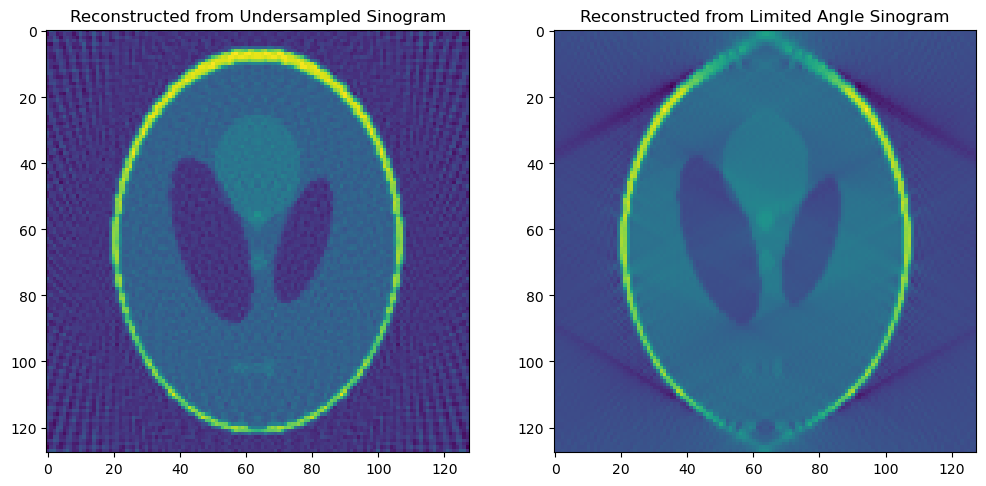

In [4]:
# Function for filtered backprojection using ASTRA
def filtered_backprojection(sinogram, angles, img_size):
    detector_count = sinogram.shape[0]  # 正弦图的列数应对应检测器的数量
    proj_geom = astra.create_proj_geom('parallel', 1.0, detector_count, angles)
    vol_geom = astra.create_vol_geom(img_size, img_size)

    # 注意：这里直接使用传入的sinogram，不进行transpose操作
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram.transpose())
    rec_id = astra.data2d.create('-vol', vol_geom)
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = astra.create_projector('strip', proj_geom, vol_geom)
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    rec_image = astra.data2d.get(rec_id)

    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(cfg['ProjectorId'])

    return rec_image

# Load the Shepp-Logan phantom image assuming already loaded as f_true
img_size = f_true.shape[0]



# Inpaint undersampled sinogram
g_corrected_under = sinogram_under

# Inpaint limited angle sinogram
g_corrected_limited = sinogram_limited

# Reconstruct images from inpainted sinograms
f_recon_under = filtered_backprojection(g_corrected_under, angles_full, img_size)
f_recon_limited = filtered_backprojection(g_corrected_limited, angles_full, img_size)

# Display the reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(f_recon_under)
plt.title('Reconstructed from Undersampled Sinogram')
plt.subplot(1, 2, 2)
plt.imshow(f_recon_limited)
plt.title('Reconstructed from Limited Angle Sinogram')
plt.show()


### Use inpainting based on an istotropic Laplacian to fill in the missing data

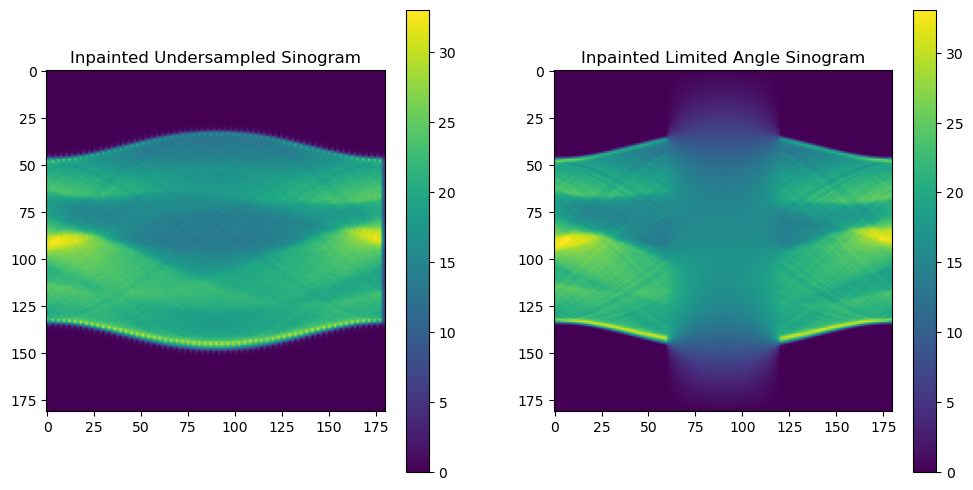

In [5]:


def laplacian_matrix(n, m):
    """
    Create a sparse Laplacian matrix for an image (or sinogram) of size n x m using 'lil' format for efficient construction.
    """
    size = n * m
    mat = lil_matrix((size, size))
    for i in range(n):
        for j in range(m):
            idx = i * m + j
            mat[idx, idx] = 4
            if i > 0:  # Not the first row
                mat[idx, idx - m] = -1  # Connect to the pixel above
            if i < n - 1:  # Not the last row
                mat[idx, idx + m] = -1  # Connect to the pixel below
            if j > 0:  # Not the first column
                mat[idx, idx - 1] = -1  # Connect to the pixel on the left
            if j < m - 1:  # Not the last column
                mat[idx, idx + 1] = -1  # Connect to the pixel on the right
    return mat.tocsr()  # Convert to CSR format for fast arithmetic operations and solvers

def inpaint_sinogram(sinogram, mask, alpha=0.1, max_iter=1000, tol=1e-5):
    """
    Inpaint a sinogram using an iterative PDE method with Dirichlet boundary conditions.
    """
    n, m = sinogram.shape
    flat_sinogram = sinogram.flatten()
    flat_mask = mask.flatten()
    L = laplacian_matrix(n, m)
    
    # Set the diagonal elements corresponding to the mask to a large number
    for i in range(len(flat_mask)):
        if flat_mask[i] == 1:
            L[i, i] = 1e4  # Large number to enforce the condition

    b = flat_sinogram * flat_mask * 1e4  # Set known values
    x = flat_sinogram.copy()  # Initial guess

    for _ in range(max_iter):
        # Solve the linear system
        x_new = spsolve(L, b)
        # Check convergence
        if np.linalg.norm(x_new - x, ord=np.inf) < tol:
            break
        x = x_new
    
    return x.reshape(n, m)


# # Create masks for the sinograms
# mask_under = np.where(sinogram_under != 0, 1, 0)
# mask_limited = np.where(sinogram_limited != 0, 1, 0)

# Define the mask for undersampled sinogram
mask_under = np.zeros_like(sinogram_under, dtype=bool)
mask_under[:, undersample_indices] = True

# Define the mask for limited angle sinogram
mask_limited = np.ones_like(sinogram_limited, dtype=bool)
mask_limited[:, index_start:index_end] = False

# Inpaint the sinograms
inpainted_under = inpaint_sinogram(sinogram_under, mask_under, alpha=0.1)
inpainted_limited = inpaint_sinogram(sinogram_limited, mask_limited, alpha=0.1)

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(inpainted_under)
plt.title('Inpainted Undersampled Sinogram')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(inpainted_limited)
plt.title('Inpainted Limited Angle Sinogram')
plt.colorbar()

plt.show()


### Apply filtered backprojection to to reconstruct the image f_recon.

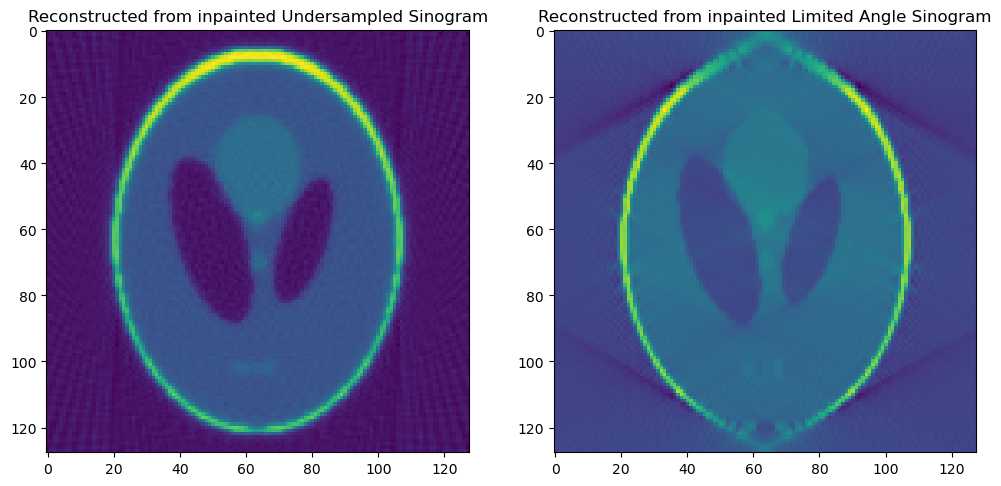

In [6]:
# Function for filtered backprojection using ASTRA
def filtered_backprojection(sinogram, angles, img_size):
    detector_count = sinogram.shape[0] 
    proj_geom = astra.create_proj_geom('parallel', 1.0, detector_count, angles)
    vol_geom = astra.create_vol_geom(img_size, img_size)


    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram.transpose())
    rec_id = astra.data2d.create('-vol', vol_geom)
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = astra.create_projector('strip', proj_geom, vol_geom)
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    rec_image = astra.data2d.get(rec_id)

    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(cfg['ProjectorId'])

    return rec_image

# Load the Shepp-Logan phantom image assuming already loaded as f_true
img_size = f_true.shape[0]



# Inpaint undersampled sinogram
g_corrected_under = inpainted_under

# Inpaint limited angle sinogram
g_corrected_limited = inpainted_limited

# Reconstruct images from inpainted sinograms
f_recon_under = filtered_backprojection(g_corrected_under, angles_full, img_size)
f_recon_limited = filtered_backprojection(g_corrected_limited, angles_full, img_size)

# Display the reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(f_recon_under)
plt.title('Reconstructed from inpainted Undersampled Sinogram')
plt.subplot(1, 2, 2)
plt.imshow(f_recon_limited)
plt.title('Reconstructed from inpainted Limited Angle Sinogram')
plt.show()


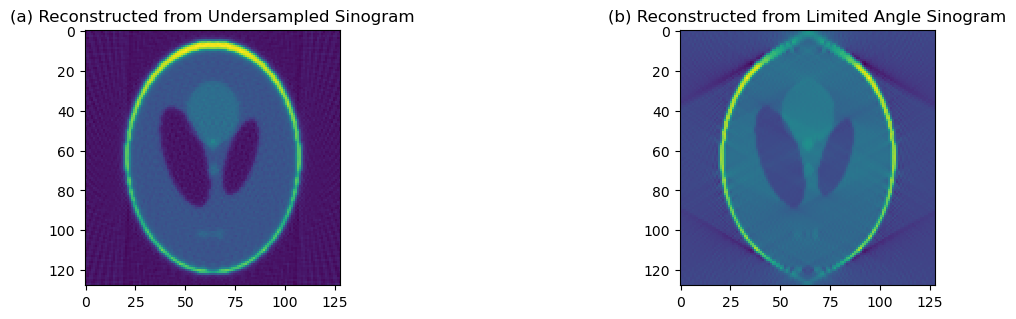

In [16]:
# Plot original and inpainted sinograms and their reconstructions
plt.figure(figsize=(18, 6))


plt.subplot(2, 3, 1)
plt.imshow(f_recon_under)
plt.title('(a) Reconstructed from Undersampled Sinogram')

plt.subplot(2, 3, 2)
plt.imshow(f_recon_limited)
plt.title('(b) Reconstructed from Limited Angle Sinogram')

plt.tight_layout()
plt.show()

### After reconstruction, investigate whether the reconstructed image can be further improved using denoising in the image domain.


#### Denoising can significantly enhance the visual quality of the reconstructed images, especially after dealing with artifacts and noise that might have been introduced during the reconstruction or inherent in the imaging process.

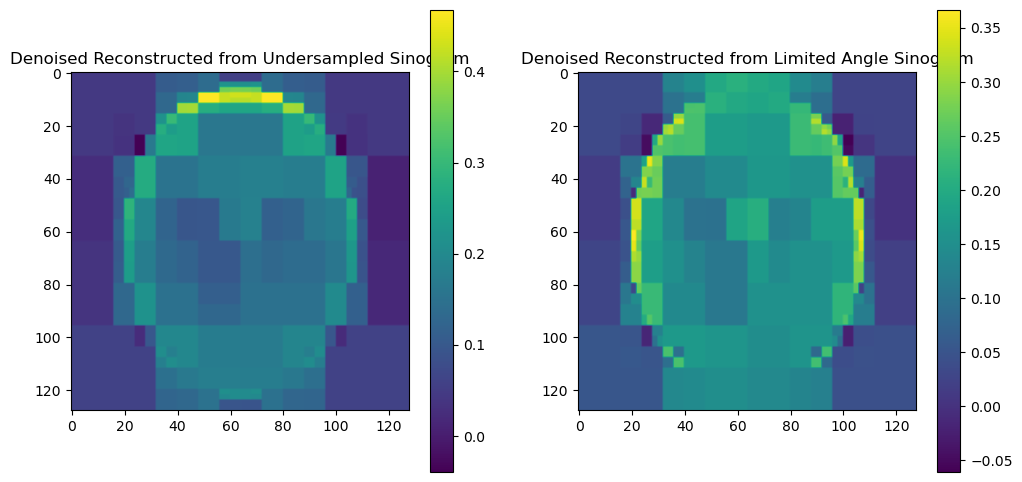

In [8]:


def apply_wavelet_denoising(image, wavelet='haar', level=3, threshold_ratio=0.2):
    # Perform wavelet decomposition
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    # Threshold is determined based on the maximum absolute value of the detail coefficients
    threshold = threshold_ratio * np.max([np.max(np.abs(details)) for coeff in coeffs[1:] for details in coeff])
    # Apply soft thresholding
    denoised_coeffs = [coeffs[0]]  # Preserve the approximation coefficients
    denoised_coeffs += [[pywt.threshold(details, threshold, mode='soft') for details in coeff] for coeff in coeffs[1:]]
    # Reconstruct the image
    return pywt.waverec2(denoised_coeffs, wavelet)

# Assuming f_recon_under and f_recon_limited are already computed reconstructed images
# Apply denoising using the adjusted parameters
denoised_under = apply_wavelet_denoising(f_recon_under, wavelet='haar', level=7)
denoised_limited = apply_wavelet_denoising(f_recon_limited, wavelet='haar', level=7)

# Display the denoised images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(denoised_under)
plt.title('Denoised Reconstructed from Undersampled Sinogram')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(denoised_limited)
plt.title('Denoised Reconstructed from Limited Angle Sinogram')
plt.colorbar()
plt.show()


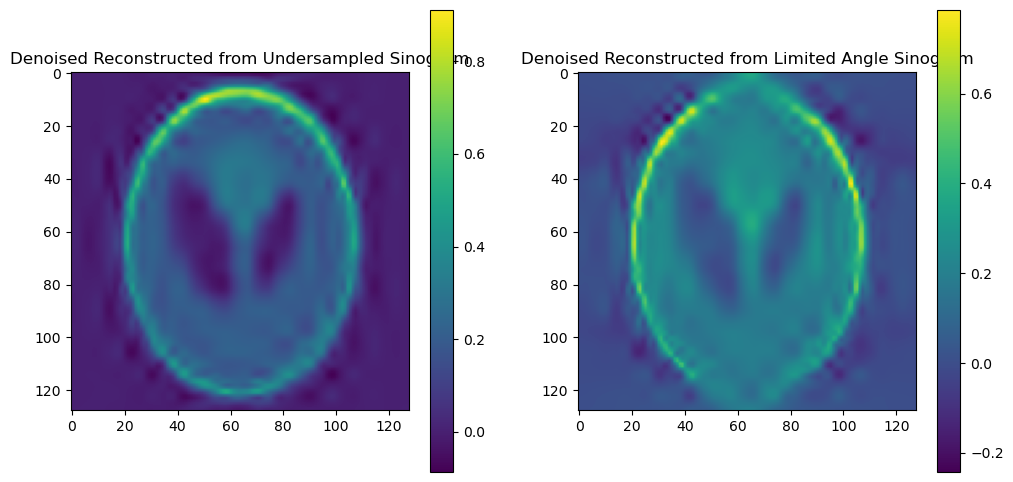

In [9]:
def apply_wavelet_denoising(image, wavelet='sym5', level=3, threshold_ratio=0.2):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    threshold = threshold_ratio * np.max([np.max(np.abs(details)) for coeff in coeffs[1:] for details in coeff])
    denoised_coeffs = [coeffs[0]] + [[pywt.threshold(details, threshold, mode='soft') for details in coeff] for coeff in coeffs[1:]]
    return pywt.waverec2(denoised_coeffs, wavelet)

denoised_under = apply_wavelet_denoising(f_recon_under, wavelet='sym5', threshold_ratio=0.2)
denoised_limited = apply_wavelet_denoising(f_recon_limited, wavelet='sym5', threshold_ratio=0.2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(denoised_under)
plt.title('Denoised Reconstructed from Undersampled Sinogram')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(denoised_limited)
plt.title('Denoised Reconstructed from Limited Angle Sinogram')
plt.colorbar()
plt.show()


### Use an anisotropic regulariser such as smoothed TV for the data correction step and compare your results

In [10]:

from scipy.sparse import diags, kron, eye, block_diag
from scipy.sparse.linalg import spsolve

def construct_laplacian(N, M):
    """Construct a 2D Laplacian matrix."""
    e = np.ones(N*M)
    diag = -4*e
    diag[N-1::N] = -3  # Last element of each row
    diag[::N] = -3     # First element of each row
    offdiag = e[1:]
    offdiag[N-1::N] = 0  # Remove wrap-arounds
    L = diags([diag, offdiag, offdiag, e, e],
              [0, -1, 1, -N, N], shape=(N*M, N*M))
    return L




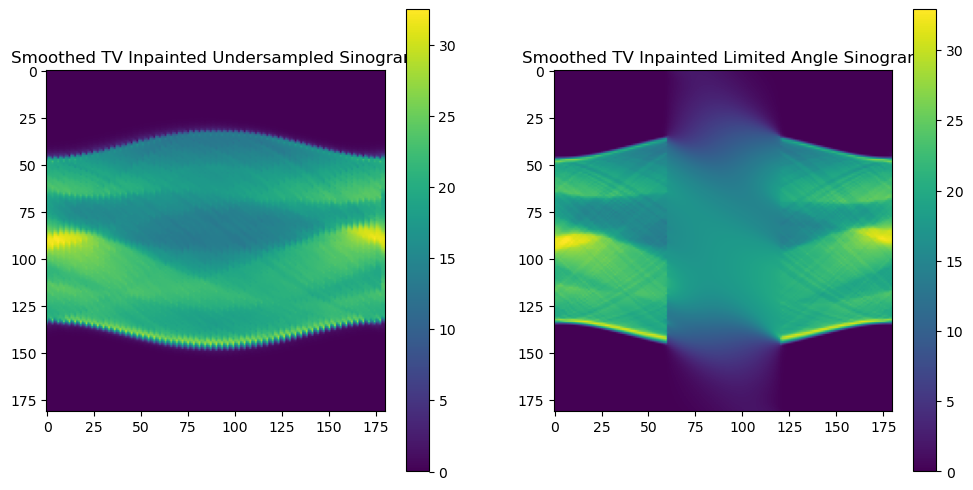

In [11]:
def smoothed_tv_inpainting(image, mask, alpha=0.1):
    """Apply smoothed TV inpainting to restore missing areas in an image."""
    N, M = image.shape
    num_pixels = N * M
    g = image.flatten()

    # Convert the boolean mask to an integer array for compatibility with diags
    mask_flat = mask.flatten().astype(int)

    # Create a sparse diagonal matrix from the mask
    A = diags(mask_flat, 0, shape=(num_pixels, num_pixels))

    # Anisotropic regularization matrix
    # Adjust weights and regularization terms as needed
    Dx = diags([-1, 1], [0, 1], shape=(N*M-1, N*M))
    Dy = diags([-1, 1], [0, N], shape=(N*M-N, N*M))

    # Gradient weights, using a simplistic exponential decay based on gradient magnitude
    grad_x = np.abs(np.diff(image, axis=1, append=0))
    grad_y = np.abs(np.diff(image, axis=0, append=0))
    weights_x = np.exp(-grad_x**2 / alpha).flatten()
    weights_y = np.exp(-grad_y**2 / alpha).flatten()

    # Construct block diagonal matrices for weights
    Mx = diags(weights_x, 0, shape=(N*M-1, N*M-1))
    My = diags(weights_y, 0, shape=(N*M-N, N*M-N))

    Regularizer = Dx.T @ Mx @ Dx + Dy.T @ My @ Dy
    ATA = A.T @ A + Regularizer
    ATg = A.T @ (g * mask_flat)  # Apply mask before solving

    # Solve the linear system
    f_recon = spsolve(ATA, ATg)
    return f_recon.reshape(N, M)

# Assuming sinogram_under and sinogram_limited have been defined properly
alpha = 0.1
smoothed_tv_inpainted_sinogram_under = smoothed_tv_inpainting(sinogram_under, mask_under, alpha=alpha)
smoothed_tv_inpainted_sinogram_limited = smoothed_tv_inpainting(sinogram_limited, mask_limited, alpha=alpha)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(smoothed_tv_inpainted_sinogram_under)
plt.title('Smoothed TV Inpainted Undersampled Sinogram')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(smoothed_tv_inpainted_sinogram_limited)
plt.title('Smoothed TV Inpainted Limited Angle Sinogram')
plt.colorbar()
plt.show()


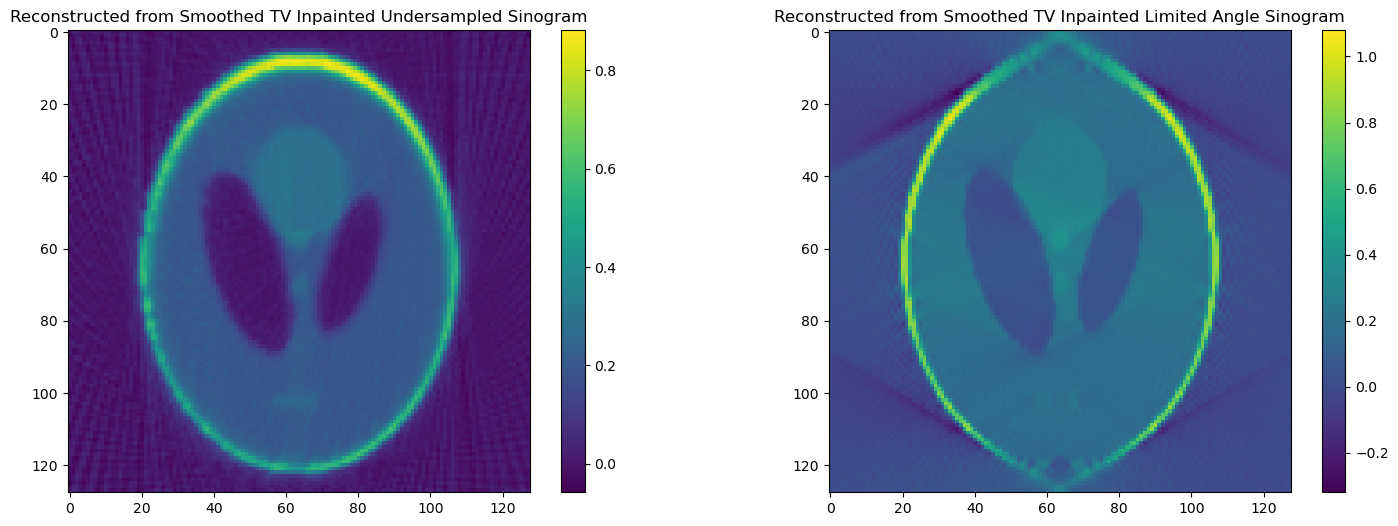

In [13]:

img_size = 128  

# Reconstruct images from sinograms that have been inpainted using smoothed TV
reconstructed_image_under = filtered_backprojection(smoothed_tv_inpainted_sinogram_under, angles_full, img_size)
reconstructed_image_limited = filtered_backprojection(smoothed_tv_inpainted_sinogram_limited, angles_full, img_size)

# Display the reconstructed images
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image_under)
plt.title('Reconstructed from Smoothed TV Inpainted Undersampled Sinogram')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_limited)
plt.title('Reconstructed from Smoothed TV Inpainted Limited Angle Sinogram')
plt.colorbar()

plt.show()

